# Verification Example: Multi-Objective 
This notebook contains a verification study to verify ROLLO's optimization capabilities. 
The Bin and Korn function is a commonly used evolutionary algorithm multi objective benchmark problem. 

## Binh and Korn Function

The [Binh and Korn function](https://ieeexplore.ieee.org/abstract/document/9264536?casa_token=tF_gorfgdTMAAAAA:GrC-2is7-C_smXEWgBJvRvJ3WEqaZU16CI1lRs0985iWypc9uPVC5HuOACzDuWqJXSio8YWFSa4)  is a two-objective function:

$$
\mathrm{Minimize} = \begin{cases}
    f_1 (x_1,x_2) = 4x_1^2+4x_2^2 \\ 
    f_2 (x_1,x_2) = (x_1-5)^2 + (x_2-5)^2
\end{cases}
$$

$$
\mathrm{Such\ that} = \begin{cases}
    (x_1-8)^2 + (x_2+3)^2 \geq 7.7 \\ 
    0 \leq x_1 \leq 5, 0 \leq x_2 \leq 3
\end{cases}
$$

Figure below shows the Binh and Korn function's Pareto front. 
![Binh and Korn Pareto Front](binh-paretofront.png)

A successful ROLLO simulation will find the Pareto front. 

The [hypervolume indicator](https://arxiv.org/abs/2005.00515)  is used to quantify the Pareto front's goodness, and is the most used set-quality indicator for assessing stochastic multiobjective optimizers. 
The hypervolume indicator measures the volume (in the objective space) covered by non-dominated solutions for problems in which all objectives are to be minimized (see [Deb](https://www.wiley.com/en-us/Multi+Objective+Optimization+using+Evolutionary+Algorithms-p-9780471873396)).

The larger the hypervolume value, the more optimized the set of solutions are. 

## ROLLO Input File 

ROLLO varies `x1` and `x2` control variables to minimize the `f1` and `f2` output parameters simultaneously. The binh and korn function calculation occurs in `binh_and_korn_calculation.py`

In [13]:
rollo_input_file = open("binh_and_korn_optimization.json", "w")
rollo_input_file.write("""{
    "control_variables": {
        "x1": {"min": 0, "max": 5},
        "x2": {"min": 0, "max": 3}
    },
    "evaluators": {
        "binh_and_korn_evaluator": {
            "order": 0,
            "input_script": ["python", "binh_and_korn_calculation.py"],
            "inputs": ["x1", "x2"],
            "output_script": ["python", "binh_and_korn_output.py"],
            "outputs": ["f1", "f2"]
        }
    },
    "constraints": {},
    "algorithm": {
        "objective": ["min", "min"],
        "optimized_variable": ["f1", "f2"],
        "weight": [1, 1],
        "pop_size": 120,
        "generations": 5,
        "parallel": "none",
        "keep_files": "none", 
        "mutation_probability": 0.23,
        "mating_probability": 0.90,
        "selection_operator": {
            "operator": "selNSGA2"
        },
        "mutation_operator": {
            "operator": "mutPolynomialBounded",
            "eta": 0.23,
            "indpb": 0.23
        },
        "mating_operator": {
            "operator": "cxBlend",
            "alpha": 0.46
        }
    }
}

""")
rollo_input_file.close()

## ROLLO `binh_and_korn_calculation.py` input script to calculate binh and korn function values (f1 and f2). 

In [14]:
binh_and_korn_calculation = open("binh_and_korn_calculation.py", "w")
binh_and_korn_calculation.write("""
import numpy as np

x1 = {{x1}}
x2 = {{x2}}
f1 = (4 * x1**2 + 4 * x2**2)
f2 = (x1 - 5)**2 + (x2 - 5)**2

print({"f1": f1, "f2": f2})
""")
binh_and_korn_calculation.close()

## binh_and_korn_output.py to return binh and korn function values to ROLLO. 

In [18]:
binh_and_korn_output = open("binh_and_korn_output.py", "w")
binh_and_korn_output.write("""
import numpy as np
import ast

file = open("binh_and_korn_evaluator_input_script_out.txt")
contents = file.read()
binh = ast.literal_eval(contents)
file.close()
print(binh)
""")
binh_and_korn_output.close()

## Run ROLLO Optimization

In [20]:
import subprocess 

subprocess.call("python -m rollo -i binh_and_korn_optimization.json", shell=True)

Entering generation 0...
       	   	     	                                                        oup                                                        	                                  ind                                  
       	   	     	-------------------------------------------------------------------------------------------------------------------	-----------------------------------------------------------------------
time   	gen	evals	avg                      	std                      	min                    	max                        	avg                    	min                    	max                    
86.3247	0  	120  	[42.84084014 21.85177405]	[30.64834208  8.90060249]	[1.11407748 4.16574002]	[134.59589925  43.27689228]	[2.47792805 1.40791555]	[0.03442282 0.01381724]	[4.98930994 2.98318489]
Entering generation 1...
       	   	     	                                                        oup                                                        	                

0

## Analyze Results Checkpoint File 

In [28]:
import pickle 
import numpy as np
from deap import creator, base, tools
import deap.benchmarks.tools as bt
import matplotlib.pyplot as plt

creator.create("obj", base.Fitness, weights=(-1.0,-1.0))
creator.create("Ind", list, fitness=creator.obj)

checkpoint_file = "checkpoint.pkl"
with open(checkpoint_file, "rb") as cp_file:
    cp = pickle.load(cp_file)

/Users/gwenchee/mambaforge3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'obj' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/gwenchee/mambaforge3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Ind' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


## ROLLO's hypervolume value increases with each generation, showing that the individuals found by ROLLO gets closer and closer to the ideal Pareto Front. 

In [34]:
results = cp["all"]
ref = np.array([120,50])
for i, pop in enumerate(results["populations"]):
    non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
    for ind in non_dom:
        ind.fitness.values = (ind.fitness.values[0], ind.fitness.values[1])
    hypervol = bt.hypervolume(non_dom, ref)
    print("Generation:", i, ", Hypervolume:", hypervol)

Generation: 0 , Hypervolume: 4234.966893909506
Generation: 1 , Hypervolume: 4267.310408321268
Generation: 2 , Hypervolume: 4294.974232379019
Generation: 3 , Hypervolume: 4320.480306090323
Generation: 4 , Hypervolume: 4325.929858749723


Text(0, 0.5, '$f_1(x_1, x_2)$')

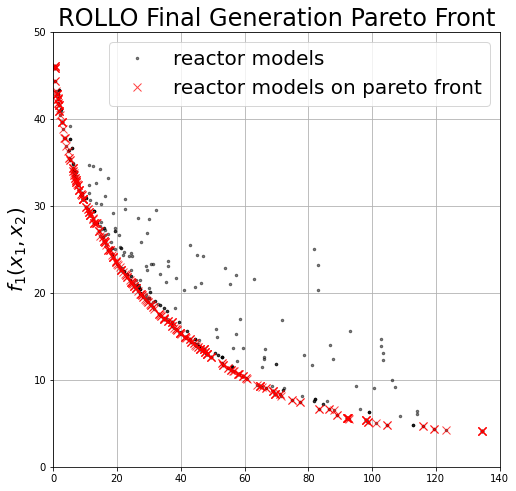

In [43]:
results = cp["all"]
pop = results["populations"][-1]
non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
all_pop = []
for p in results["populations"]:
    for i in p:
        all_pop.append(i)
non_dom_all = tools.sortNondominated(all_pop, k=len(all_pop), first_front_only=True)[0]

fig, ax = plt.subplots(figsize=(8,8))
count1, count2 = 0, 0
for ind in all_pop:
    if count1 == 0:
        ax.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', ms=5, alpha=0.5, label="reactor models")
        count1 += 1
    else:
        ax.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', ms=5, alpha=0.5)
for ind in non_dom_all:
    if count2 == 0:
        ax.plot(ind.fitness.values[0], ind.fitness.values[1], 'rx', alpha=0.74, ms=8, label="reactor models on pareto front")
        count2 += 1
    else:
        ax.plot(ind.fitness.values[0], ind.fitness.values[1], 'rx', alpha=0.74, ms=8)
ax.set_title('ROLLO Final Generation Pareto Front',fontsize=24)
ax.grid()
ax.set_xlim([0,140])
ax.set_ylim([0,50])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=20, bbox_to_anchor = [1.0, 1.0])
ax.set_ylabel("$f_2(x_1, x_2)$", fontsize=20)
ax.set_ylabel("$f_1(x_1, x_2)$", fontsize=20)

# ROLLO's final generation successfully found a set of widely spread out individuals on the Binh and Korn's Pareto Front. 